# Trade Algorithm to Automate Short Position Trades Using Daily Patterns


Only allowed short positions (selling first, buying later)


Max. stop loss 7% of initial investment


Max. take profit 14%-21% of initial investment (2:1/3:1 risk-reward ratio depending on leverage)


Support and Resistance levels calculated using anticipated pct. change in price over last 5 days


# Key Considerations Added to Simplified Structure:
## 1. Get historical data of the asset(s)
1.1. Verify data quality and check for missing values/outliers.


1.2. Account for trading volumes, volatility, and any specific asset-related adjustments.


1.3. Pull leverage-related information.


## 2. Calculate entry and exit points
2.1. Calculate anticipated pct. change in the price over the last 5 trading days.


2.2. Calculate support and resistance levels.


2.3. Ensure support/resistance levels align with leverage and volatility.
## 3. Risk Management
3.1. Set stop loss (max 7%) and take profit (between 14%-21%) based on risk-reward ratio.


3.2. Calculate position size that adheres to max stop loss and keeps total risk within acceptable boundaries.


3.3. Take leverage into consideration when calculating actual exposure and risk.
## 4. Execute the trade using Kraken REST API
4.1. Set up connection with Kraken API (handle authentication).


4.2. Monitor trade after execution for any trailing stop conditions or adjustments.


4.3. Log trades, including entries, exits, wins, and losses for further analysis. -->

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import requests
import datetime
import hashlib
from difflib import get_close_matches
import hmac
import base64
import time
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import urllib.parse

# Import config file
import sys
sys.path.insert(0, '../')
import config as cfg

In [2]:
api_key = cfg.api_key
private_key = cfg.api_priv

## API Fetchin

In [3]:
api_url = "https://api.kraken.com"

# Create dictionary to map API endpoints to their respective names and respective request types
api_endpoints = {
    'Assets': '/0/public/Assets',
    'AssetPairs': '/0/public/AssetPairs',
    'Ticker': '/0/public/Ticker',
    'OHLC': '/0/public/OHLC',
    'default OHLC': '/0/public/OHLC',

    'Balance': '/0/private/Balance',
    'ExtendedBalance': '/0/private/BalanceEx',
    'Ledgers': '/0/private/Ledgers',
    'QueryLedgers': '/0/private/QueryLedgers',
    'TradeVolume': '/0/private/TradeVolume',
    'TradesHistory': '/0/private/TradesHistory',
    'OpenOrders': '/0/private/OpenOrders',

}

# Function to generate a nonce
def generate_nonce():
    nonce = str(int(1000 * time.time()))
    return nonce

# Function to get Kraken signature
def get_kraken_signature(urlpath, data, secret):
    postdata = urllib.parse.urlencode(data)
    encoded = (str(data['nonce']) + postdata).encode()
    message = urlpath.encode() + hashlib.sha256(encoded).digest()

    mac = hmac.new(base64.b64decode(secret), message, hashlib.sha512)
    sigdigest = base64.b64encode(mac.digest())
    return sigdigest.decode() 

# Function to make Kraken API request
def kraken_request(uri_path, data, api_key, api_sec, headers=None):
    if headers is None:
        headers = {}

    headers['API-Key'] = api_key
    headers['API-Sign'] = get_kraken_signature(uri_path, data, api_sec)
    req = requests.post((api_url + uri_path), headers=headers, data=data)
    return req

#Function to make more non-trivial Kraken API get request
def kraken_get_request(uri_path, data=None, headers=None):
    if uri_path != api_endpoints['OHLC']:
        if headers is None:
            headers = {
                'Accept': 'application/json'
            }
        
        headers.update(headers)
        req = requests.get((api_url + uri_path), headers=headers, data=data)
    elif uri_path == api_endpoints['OHLC']:
        temp_endpoint = api_endpoints['OHLC'] + '?pair=' + data['pair'] + '&interval=' + data['interval']
        req = requests.get((api_url + temp_endpoint), headers=headers)
    return req


In [4]:
# Possible intervals: 1, 5, 15, 30, 60, 240, 1440, 10080, 21600 in minutes i.e., 1 minute, 5 minutes, 15 minutes, 30 minutes, 1 hour, 4 hours, 1 day, 1 week, 1 month
# Possible tenures: 1D (1440), 7D (10080), 1M (43200), 3M (129600), 6M (259200), 1Y (518400) - corresponding intervals are tenure/720 to maximize data points from a single request
possible_intervals =[1, 5, 15, 30, 60, 240, 1440, 10080, 21600]
possible_timeframes = {'1D': 1440, '7D': 10080, '1M': 43200, '3M': 129600, '6M': 259200, '1Y': 518400}

tenure = '7D'


In [5]:
# 1. Get Historical OHLC Data of the Asset(s) using Kraken REST API
# Function to grab the OHLC data for a given list of asset pairs
def grab_ohlc_data(assetPairs,tenure):
    # divide timerframe by 720 to get the interval but use the next larger closet possible interval
    interval = min([i for i in possible_intervals if i >= possible_timeframes[tenure]/720], default=possible_intervals[-1])
    interval = str(interval)
    # Construct since parameter for the OHLC request using tenure and datetime unix converted timestamp, i.e., subtracting the tenure from the current time and equating it to the since parameter
    since = int(time.time()) - possible_timeframes[tenure]*60
    since = str(since)

    # Construct the Kraken API request and get the OHLC data for the given asset pairs, ohlc grabbing requires use of a temporary endpoint for the OHLC url
    ohlcDict = {}
    for assetPair in assetPairs:
        resp = kraken_get_request(api_endpoints['OHLC'], {"pair": assetPair, "interval": interval, "since": since}).json()
        if resp['error'] == KeyError:
            #skip this asset pair
            continue
        ohlcDict[assetPair] = list(resp['result'].values())
        # To process the response, we need to extract the OHLC data from the response particularly the tick data array and the last timestamp
    # Append the OHLC data to a dataframe and return the dataframe with columns: Time, Open, High, Low, Close, Volume, Count, name it after the asset pair
    return ohlcDict

# 2. Calculate Entry and Exit Points
# 2.1 Calculate anticipated percentage change in price using Linear Regression or Neural Networks
def calculate_anticipated_pct_change(data, method='NN'):
    if method == 'LR':
        # Using Linear Regression to Predict Percentage Change
        model = LinearRegression()
        data['Days'] = range(len(data))  # Add a column representing the number of days for fitting
        X = data[['Days']]
        y = data['Close']
        model.fit(X, y)
        predicted_price = model.predict([[len(data)]])[0]  # Predicting the next value
        anticipated_pct_change = ((predicted_price - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100
    else:    
        # Alternatively, using a simple Neural Network with TensorFlow
        # Prepare data for Neural Network
        features = np.array(data[['Days']])
        target = np.array(data['Close'])
        model_nn = tf.keras.Sequential([
            tf.keras.layers.Dense(10, activation='relu', input_shape=(1,)),
            tf.keras.layers.Dense(1)
        ])
        model_nn.compile(optimizer='adam', loss='mse')
        model_nn.fit(features, target, epochs=100, verbose=0)
        predicted_price_nn = model_nn.predict([[len(data)]])[0][0]
        anticipated_pct_change_nn = ((predicted_price_nn - data['Close'].iloc[-1]) / data['Close'].iloc[-1]) * 100

        # Combining the results from Linear Regression and Neural Network for better estimation
        anticipated_pct_change = (anticipated_pct_change + anticipated_pct_change_nn) / 2
    return anticipated_pct_change

# 2.2 Calculate support and resistance levels
def calculate_support_resistance(data, anticipated_pct_change):
    current_price = data['Close'].iloc[-1]
    resistance_level = current_price * (1 + anticipated_pct_change / 100)
    support_level = current_price * (1 - anticipated_pct_change / 100)
    return support_level, resistance_level

# 3. Risk Management
# 3.1 Calculate stop loss and take profit levels based on desired risk-reward ratio
def calculate_risk_management_levels(entry_price, risk_reward_ratio):
    stop_loss = entry_price * (1 - 0.07)  # Max stop loss 7%
    take_profit = entry_price * (1 + (risk_reward_ratio * 0.07))  # Take profit based on risk-reward ratio
    return stop_loss, take_profit

# 3.2 Calculate position size
def calculate_position_size(total_capital, entry_price, stop_loss):
    risk_per_trade = total_capital * 0.02  # Assume 2% risk of total capital per trade
    position_size = risk_per_trade / abs(entry_price - stop_loss)
    return position_size

# 4. Execute Trade Using Kraken REST API
def execute_trade(api_key, private_key, asset_symbol, position_size, entry_price, order_type="sell"):
    api_url = "https://api.kraken.com/0/private/AddOrder"
    nonce = str(int(time.time() * 1000))
    
    # Data payload for the trade
    data = {
        "nonce": nonce,
        "ordertype": "limit",
        "type": order_type,  # "sell" for short positions
        "volume": position_size,
        "pair": asset_symbol,
        "price": entry_price,
        "leverage": "2:1"  # Example leverage, can be adjusted
    }
    
    # Create the Kraken API signature
    postdata = urllib.parse.urlencode(data)
    message = (nonce + postdata).encode()
    sha256 = hashlib.sha256(nonce.encode() + postdata.encode()).digest()
    hmac_key = base64.b64decode(private_key)
    signature = hmac.new(hmac_key, b"/0/private/AddOrder" + sha256, hashlib.sha512)
    signature_b64 = base64.b64encode(signature.digest())
    
    headers = {
        "API-Key": api_key,
        "API-Sign": signature_b64.decode()
    }
    
    response = requests.post(api_url, headers=headers, data=data)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception("Failed to execute trade: " + response.text)


In [10]:
assetList = ['XXRP','SOL', 'XXBT', 'TIA', 'TAO', 'OP','FLR','AXS']

In [11]:
allAssetPairs = kraken_get_request(api_endpoints['AssetPairs'], headers={'country_code':'GB'}).json()['result']

# Filter the asset pairs based on the assetList and quote currency
# tradeablePairs = [
#     {key: asset[key] for key in ['altname','base', 'quote', 'ordermin', 'fees', 'fees_maker','leverage_buy', 'leverage_sell']}
#     for asset in allAssetPairs.values() if asset['quote'] == 'ZUSD'
# ]

tradeablePairs = [
    {key: asset[key] for key in ['altname','base', 'quote', 'ordermin', 'fees', 'fees_maker','leverage_buy', 'leverage_sell']}
    for asset in allAssetPairs.values() if asset['wsname'][-3:] == 'USD'
]


# Check if asset['base'] is in the assetList
filteredPairs = [asset for asset in tradeablePairs if asset['base'] in assetList]


# Get the OHLC data for the filtered asset pairs
#ohlcData = grab_ohlc_data([asset['base'] + asset['quote'] for asset in filteredPairs], tenure)
ohlcData = grab_ohlc_data([asset['altname'] for asset in filteredPairs], tenure)

# Create separate DataFrame for each asset
ohlcDFs = {}
for asset, rows in ohlcData.items():
    # Flatten rows and convert to DataFrame
    df = pd.DataFrame(rows[0], columns=["Time", "Open", "High", "Low", "Close", "VWAP", "Volume", "Count"])
    
    # Convert 'Time' to datetime
    df['Time'] = pd.to_datetime(df['Time'], unit='s')

    # Split to date and time
    # df['Date'] = df['Time'].dt.date
    # df['Time'] = df['Time'].dt.time
    
    # Convert necessary columns to numeric
    df[['Open', 'High', 'Low', 'Close', 'VWAP', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'VWAP', 'Volume']].apply(pd.to_numeric)
    
    # Convert Time to index
    #df.set_index("Time", inplace=True)
    
    # Calculate Moving Averages, 9 and 21 day
    df['9 day MA'] = df['Close'].rolling(window=9).mean().shift(1)#.shift(1) to avoid look-ahead bias
    df['21 day MA'] = df['Close'].rolling(window=21).mean().shift(1)#.shift(1) to avoid look-ahead bias
    df['9 day EMA'] = df['Close'].ewm(span=9, adjust=False).mean()
    df['21 day EMA'] = df['Close'].ewm(span=21, adjust=False).mean()
 
    # Store DataFrame in a dictionary with asset name
    ohlcDFs[asset] = df

ohlcDFs.pop('XBTPYUSD')

# Calculate signals based on Moving Average Differences, add to new columns, 1 if 9 day MA > 21 day MA, -1 if 9 day MA < 21 day MA, 0 otherwise, Singla MA and Signal EMA
# Add instantaneous return/system return column
for asset, df in ohlcDFs.items():
    df['Signal MA'] = np.where(df['9 day MA'] > df['21 day MA'], 1, np.where(df['9 day MA'] < df['21 day MA'], -1, 0))
    df['Signal EMA'] = np.where(df['9 day EMA'] > df['21 day EMA'], 1, np.where(df['9 day EMA'] < df['21 day EMA'], -1, 0))
    df['Return'] = np.log(df['Close']).diff()#.pct_change()
    df['System Return MA'] = df['Signal MA'] * df['Return']
    df['System Return EMA'] = df['Signal EMA'] * df['Return']
    df['Signal'] = 0
    df['Signal'] = np.where(df['9 day EMA'] > df['21 day EMA'], 1, 0)
    df['Signal'] = np.where(df['9 day EMA'] < df['21 day EMA'], -1, df['Signal'])
    df['Position'] = df['Signal'].diff()

    df.dropna(inplace=True) # Drop rows with NaN values, shifted rows before 21 days MA calculation

# show 9thto 25th row of first df
#ohlcDFs['XRPUSD'].iloc[0:25]

# Show first instance where position is non zero
#ohlcDFs['XRPUSD'][ohlcDFs['XRPUSD']['Position'] != 0].head(2

# Calculate the anticipated percentage change in price using Neural Networks
# anticipated_pct_changes = {}
# for asset, df in ohlcDFs.items():
#     anticipated_pct_changes[asset] = calculate_anticipated_pct_change(df['Close'])

# # Calculate support and resistance levels
# support_resistance_levels = {}
# for asset, df in ohlcDFs.items():
#     support_resistance_levels[asset] = calculate_support_resistance(df, anticipated_pct_changes[asset])


# # Calculate risk management levels
# risk_reward_ratio = 3  # Assume 3:1 risk-reward ratio
# risk_management_levels = {}
# for asset, df in ohlcDFs.items():
#     entry_price = df['Close'].iloc[-1]
#     risk_management_levels[asset] = calculate_risk_management_levels(entry_price, risk_reward_ratio)

# # Calculate position size
# total_capital = 10000  # Total capital in USD
# position_sizes = {}
# for asset, df in ohlcDFs.items():
#     entry_price = df['Close'].iloc[-1]
#     stop_loss = risk_management_levels[asset][0]
#     position_sizes[asset] = calculate_position_size(total_capital, entry_price, stop_loss)


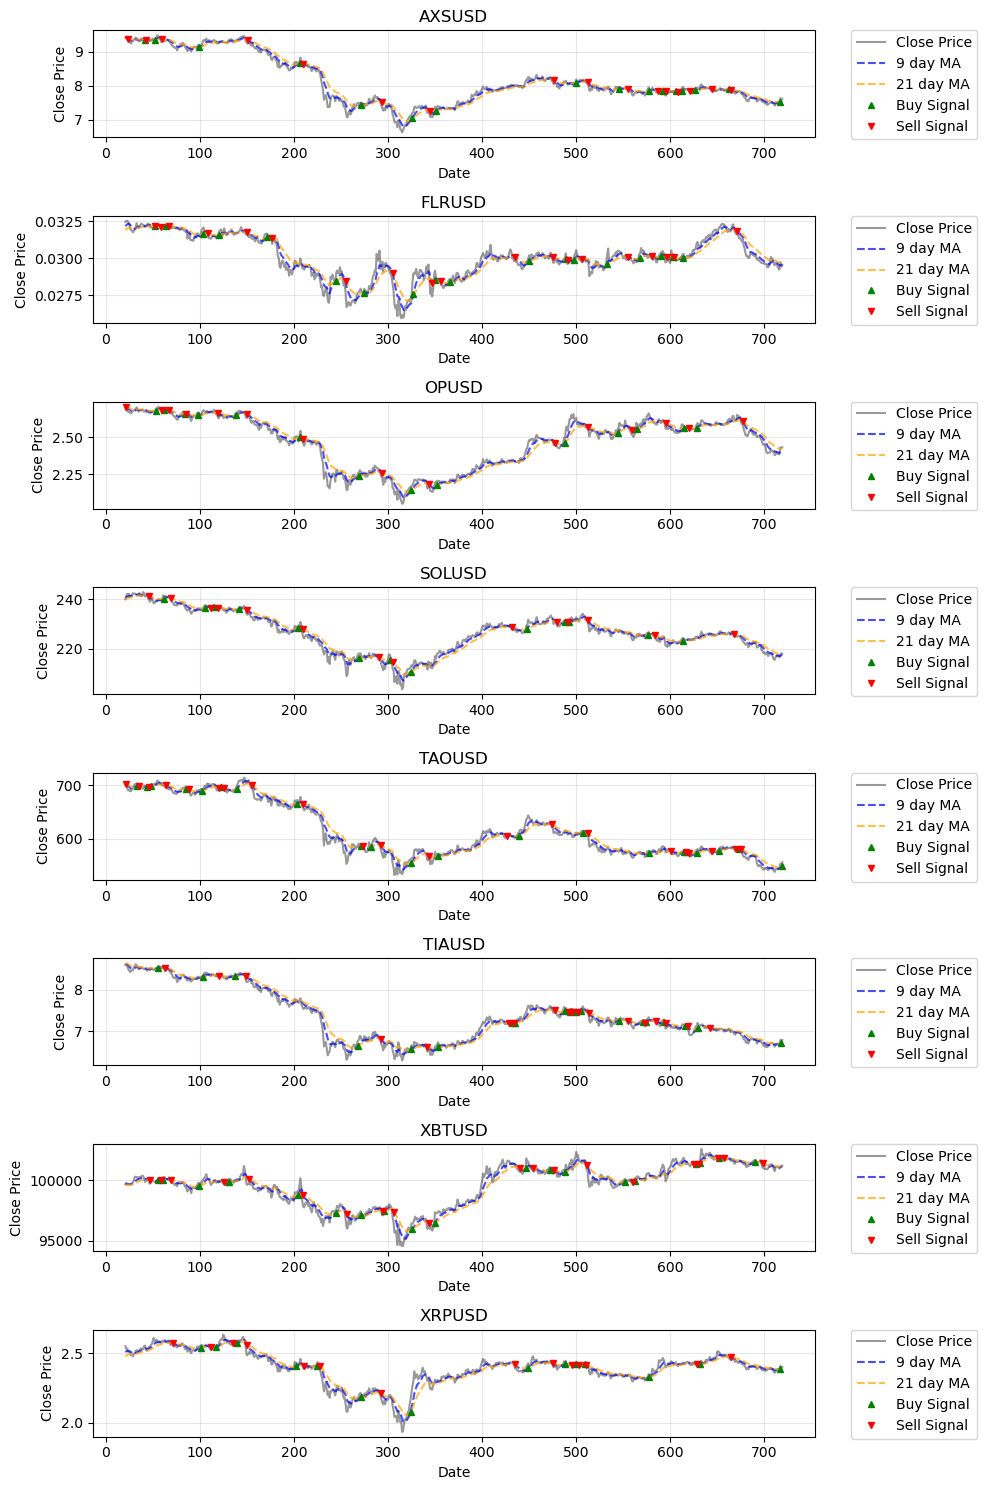

In [12]:
# Plot Closing Prices for all assets on separate subplots
# Plot 9 and 21 day Moving Averages
# Plot Buy and Sell Signals
# Plot System Returns for Moving Average and Exponential Moving Average Strategies on the right of the price plot
# Plot the anticipated percentage change in price as a horizontal line on the price plot

fig, axes = plt.subplots(nrows=len(ohlcDFs), ncols=1, figsize=(10,15))

for i, (asset, df) in enumerate(ohlcDFs.items()):
    df['Close'].plot(ax=axes[i], title=asset, color='k', label='Close Price', alpha=0.4)
    df['9 day EMA'].plot(ax=axes[i], color='b', linestyle='--', label='9 day MA', alpha=0.7)
    df['21 day EMA'].plot(ax=axes[i], color='orange', linestyle='--', label='21 day MA', alpha=0.7)
    axes[i].plot(df[-711:].loc[df['Position'] == 2].index, df[-711:]['9 day EMA'][df['Position'] == 2], '^', color='g', markersize=5, label='Buy Signal')
    axes[i].plot(df[-711:].loc[df['Position'] == -2].index, df[-711:]['9 day EMA'][df['Position'] == -2], 'v', color='r', markersize=5, label='Sell Signal')
    axes[i].set_ylabel('Close Price')
    axes[i].set_xlabel('Date')
    axes[i].grid(alpha=0.3)
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()


In [9]:
# Step 2: Calculate Entry and Exit Points
anticipated_pct_change = calculate_anticipated_pct_change(ohlcDFs[assetPair])
support_level, resistance_level = calculate_support_resistance(ohlcDFs[assetPair], anticipated_pct_change)

# Step 3: Risk Management
entry_price = ohlcDFs[assetPair]['Close'].iloc[-1]
risk_reward_ratio = 3  # Example risk-reward ratio
stop_loss, take_profit = calculate_risk_management_levels(entry_price, risk_reward_ratio)
total_capital = 10000  # Example total capital
position_size = calculate_position_size(total_capital, entry_price, stop_loss)

# Plot the historical data with support and resistance levels for each symbol in ohlcDFs
fig, axs = plt.subplots(len(ohlcDFs), figsize=(12, 6 * len(ohlcDFs)))
if len(ohlcDFs) == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one subplot

for i, (asset_symbol, df) in enumerate(ohlcDFs.items()):
    support_level, resistance_level = calculate_support_resistance(df, anticipated_pct_change)
    
    axs[i].plot(df['Time'], df['Close'], label='Close Price')
    axs[i].axhline(y=support_level, color='g', linestyle='--', label='Support Level')
    axs[i].axhline(y=resistance_level, color='r', linestyle='--', label='Resistance Level')
    axs[i].set_title(f"Price Chart for {asset_symbol}")
    axs[i].set_xlabel("Date")
    axs[i].set_ylabel("Price")
    axs[i].legend()

plt.tight_layout()
plt.show()

# Plot risk management levels
plt.figure(figsize=(12, 6))
plt.plot(ohlcDFs[assetPair]['Time'], ohlcDFs[assetPair]['Close'], label='Close Price')
plt.axhline(y=stop_loss, color='r', linestyle='--', label='Stop Loss')
plt.axhline(y=take_profit, color='g', linestyle='--', label='Take Profit')
plt.title(f"Risk Management Levels for {assetPair}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Step 4: Execute the Trade
#trade_response = execute_trade(api_key, private_key, asset_symbol, position_size, entry_price)
#print("Trade executed successfully:", trade_response)   

NameError: name 'assetPair' is not defined